<a href="https://colab.research.google.com/github/bhushanmandava/basic_transformer_architecture/blob/main/transformer_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

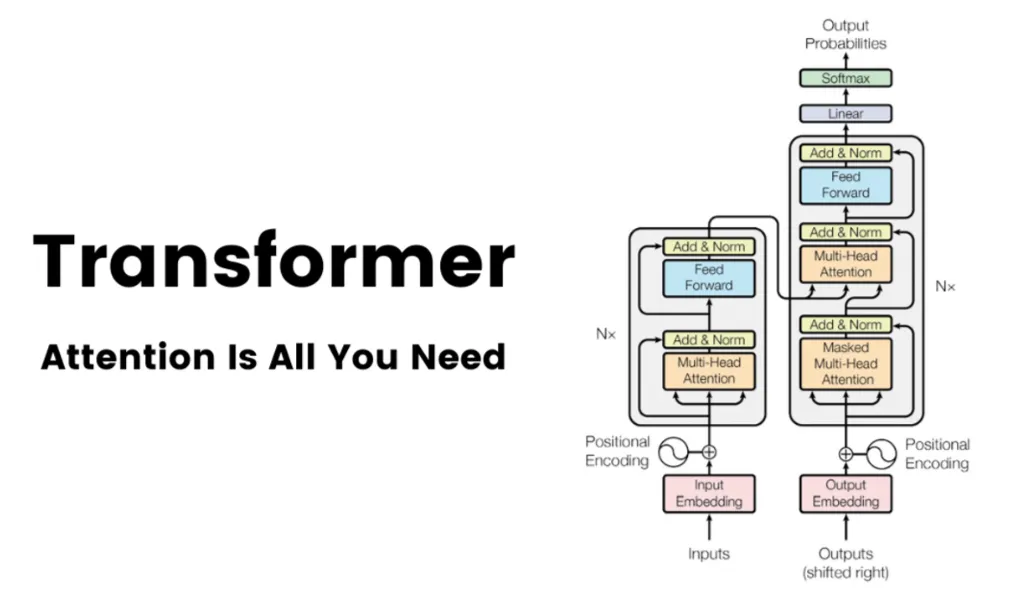

## for this code we are only using decoder only part which most of the large language models use

In [ ]:
!pip install --upgrade setuptools pip
!pip install torch lightning


## importing the required modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import lightning as L#it is to we can scale our code easily


## Create the input and output and data

In [ ]:
token_to_id = {'what' : 0,
               'is' : 1,
               'transformer' : 2,
               'attention': 3,
               '<EOS>' : 4}

id_to_token = dict(map(reversed, token_to_id.items()))

inputs = torch.tensor([[token_to_id["what"],
                        token_to_id["is"],
                        token_to_id["transformer"],
                        token_to_id["<EOS>"],
                        token_to_id["attention"]],

                       [token_to_id["transformer"],
                        token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["attention"]]])

labels = torch.tensor([[token_to_id["is"],
                        token_to_id["transformer"],
                        token_to_id["<EOS>"],
                        token_to_id["attention"],
                        token_to_id["<EOS>"]],

                       [token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["attention"],
                        token_to_id["<EOS>"]]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)


## step2: positional encoding
we are proceeding direclty to step 2 beacuse we gonna nn.Embedding for our word embedding step

In [ ]:
class PositionEncoding(nn.Module):

    def __init__(self, d_model=2, max_len=6):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        return word_embeddings + self.pe[:word_embeddings.size(0), :]


## step 3: Attention is all you need with a mask

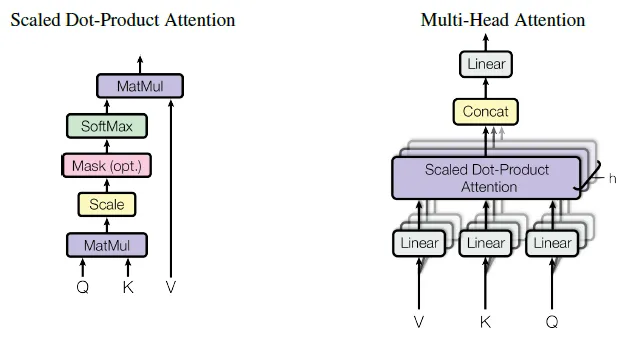

In [ ]:
class Attention(nn.Module):

    def __init__(self, d_model=2):
        super().__init__()

        self.d_model = d_model
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

        self.row_dim = 0
        self.col_dim = 1

    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        q = self.W_q(encodings_for_q)
        k = self.W_k(encodings_for_k)
        v = self.W_v(encodings_for_v)

        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))
        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5)

        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)

        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)
        attention_scores = torch.matmul(attention_percents, v)

        return attention_scores



## step 4: residual connection and fully connected layer

In [ ]:
class DecoderOnlyTransformer(L.LightningModule):

    def __init__(self, num_tokens=4, d_model=2, max_len=6):
        super().__init__()

        L.seed_everything(seed=42)

        self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model, max_len=max_len)
        self.self_attention = Attention(d_model=d_model)
        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, token_ids):
        word_embeddings = self.we(token_ids)
        position_encoded = self.pe(word_embeddings)
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0)), device=self.device))
        mask = mask == 0
        self_attention_values = self.self_attention(position_encoded, position_encoded, position_encoded, mask=mask)
        residual_connection_values = position_encoded + self_attention_values
        fc_layer_output = self.fc_layer(residual_connection_values)
        return fc_layer_output

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_tokens, labels = batch
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])
        return loss


## model prediction without any training

In [ ]:
model = DecoderOnlyTransformer(num_tokens=len(token_to_id), d_model=2, max_len=6)

model_input = torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["transformer"],
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

max_length = 6
for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]):
        break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Predicted Tokens:

	 <EOS>


## model training

In [ ]:
trainer = L.Trainer(max_epochs=30)
trainer.fit(model, train_dataloaders=dataloader)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 10     | tra

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## prediuction after training

In [ ]:
model_input = torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["transformer"],
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]):
        break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 attention
	 <EOS>


In [ ]:
model_input = torch.tensor([token_to_id["transformer"],
                            token_to_id["is"],
                            token_to_id["what"],
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 attention
	 <EOS>
